<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/mmlu_eval_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building an MMLU Eval

This notebook shows how to:
- Build and run an eval
- Load the results and into a Pandas Dataframe

We use the `evals.elsuite.basic.match:Match` Eval class here to check whether new completions match the correct answer. Under the hood, it will generate a completion with the choice of model for each prompt, check if the completion matches the true answer, then logs a result.

In [ ]:
!pip install colab-env --upgrade -q
!pip install openai -q

In [ ]:
!git clone https://github.com/openai/evals.git

In [ ]:
# Install, and download MMLU if you haven't already
%cd /content/evals/
%pip install -e . -q

In [ ]:
%cd /content/
!curl -O https://people.eecs.berkeley.edu/~hendrycks/data.tar
!tar -xf data.tar
data_path = "data"

In [ ]:
import pandas as pd
import os

# Assuming this notebook is in examples/
registry_path = os.path.join(os.getcwd(), "/content/evals/registry")
print(registry_path)

In [6]:
# Build the prompts using Chat format. We support converting Chat conversations to text for non-Chat models

choices = ["A", "B", "C", "D"]
sys_msg = "The following are multiple choice questions (with answers) about {}."
def create_chat_prompt(sys_msg, question, answers, subject):
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": sys_msg.format(subject)},
        {"role": "user", "content": user_prompt}
    ]

def create_chat_example(question, answers, correct_answer):
    """
    Form few-shot prompts in the recommended format: https://github.com/openai/openai-python/blob/main/chatml.md#few-shot-prompting
    """
    user_prompt = f"{question}\n" + "\n".join([f"{choice}. {answer}" for choice, answer in zip(choices, answers)]) + "\nAnswer:"
    return [
        {"role": "system", "content": user_prompt, "name": "example_user"},
        {"role": "system", "content": correct_answer, "name": "example_assistant"},
    ]

In [7]:
data_path='/content/data'

In [8]:
import yaml
subjects = sorted([f.split("_test.csv")[0] for f in os.listdir(os.path.join(data_path, "test")) if "_test.csv" in f])

registry_yaml = {}

for subject in subjects:
    subject_path = os.path.join(registry_path, "data", "mmlu", subject)
    os.makedirs(subject_path, exist_ok=True)

    # Create few-shot prompts
    dev_df = pd.read_csv(os.path.join(data_path, "dev", subject + "_dev.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    dev_df["sample"] = dev_df.apply(lambda x: create_chat_example(x["Question"], x[["A", "B", "C", "D"]], x["Answer"]), axis=1)
    few_shot_path = os.path.join(subject_path, "few_shot.jsonl")
    dev_df[["sample"]].to_json(few_shot_path, lines=True, orient="records")

    # Create test prompts and ideal completions
    test_df = pd.read_csv(os.path.join(data_path, "test", subject + "_test.csv"), names=("Question", "A", "B", "C", "D", "Answer"))
    test_df["input"] = test_df.apply(lambda x: create_chat_prompt(sys_msg, x["Question"], x[["A", "B", "C", "D"]], subject), axis=1)
    test_df["ideal"] = test_df.Answer
    samples_path = os.path.join(subject_path, "samples.jsonl")
    test_df[["input", "ideal"]].to_json(samples_path, lines=True, orient="records")

    eval_id = f"match_mmlu_{subject}"

    registry_yaml[eval_id] = {
        "id": f"{eval_id}.test.v1",
        "metrics": ["accuracy"]
    }
    registry_yaml[f"{eval_id}.test.v1"] = {
        "class": "evals.elsuite.basic.match:Match",
        "args": {
            "samples_jsonl": samples_path,
            "few_shot_jsonl": few_shot_path,
            "num_few_shot": 4,
        }
    }
registry_path = '/content'
with open(os.path.join(registry_path, "evals", "mmlu.yaml"), "w") as f:
    yaml.dump(registry_yaml, f)

In [9]:
import colab_env
import os
import openai
from openai import OpenAI
client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

Mounted at /content/gdrive


In [10]:
from openai import OpenAI
client = OpenAI()

modellist=client.models.list()
modellist.data

[Model(id='dall-e-3', created=1698785189, object='model', owned_by='system'),
 Model(id='gpt-4-1106-preview', created=1698957206, object='model', owned_by='system'),
 Model(id='whisper-1', created=1677532384, object='model', owned_by='openai-internal'),
 Model(id='davinci-002', created=1692634301, object='model', owned_by='system'),
 Model(id='gpt-4-0125-preview', created=1706037612, object='model', owned_by='system'),
 Model(id='gpt-4-turbo-preview', created=1706037777, object='model', owned_by='system'),
 Model(id='babbage-002', created=1692634615, object='model', owned_by='system'),
 Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'),
 Model(id='gpt-3.5-turbo-16k', created=1683758102, object='model', owned_by='openai-internal'),
 Model(id='tts-1-hd-1106', created=1699053533, object='model', owned_by='system'),
 Model(id='tts-1-hd', created=1699046015, object='model', owned_by='system'),
 Model(id='gpt-4', created=1687882411, object='model', owned_by='openai'

In [11]:
#'mmlu-abstract-algebra', 'mmlu-abstract-algebra.val.ab-v1', 'mmlu-anatomy',
#'mmlu-anatomy.val.ab-v1', 'mmlu-astronomy', 'mmlu-astronomy.val.ab-v1',
#'mmlu-business-ethics', 'mmlu-business-ethics.val.ab-v1', 'mmlu-clinical-knowledge',
#'mmlu-clinical-knowledge.val.ab-v1', 'mmlu-college-biology', 'mmlu-college-biology.val.ab-v1',
#'mmlu-college-chemistry', 'mmlu-college-chemistry.val.ab-v1', 'mmlu-college-computer-science',
#'mmlu-college-computer-science.val.ab-v1', 'mmlu-college-mathematics',
#'mmlu-college-mathematics.val.ab-v1', 'mmlu-college-medicine',
#'mmlu-college-medicine.val.ab-v1', 'mmlu-college-physics', 'mmlu-college-physics.val.ab-v1',
#'mmlu-computer-security', 'mmlu-computer-security.val.ab-v1', 'mmlu-conceptual-physics',
#'mmlu-conceptual-physics.val.ab-v1', 'mmlu-econometrics', 'mmlu-econometrics.val.ab-v1',
#'mmlu-electrical-engineering', 'mmlu-electrical-engineering.val.ab-v1',
#'mmlu-elementary-mathematics', 'mmlu-elementary-mathematics.val.ab-v1',
#'mmlu-formal-logic', 'mmlu-formal-logic.val.ab-v1', 'mmlu-global-facts',
#'mmlu-global-facts.val.ab-v1', 'mmlu-high-school-biology', 'mmlu-high-school-biology.val.ab-v1',
#'mmlu-high-school-chemistry'

In [12]:
# This will generate a JSONL which will record samples and logs and store it in /tmp/evallogs
#!oaieval gpt-3.5-turbo match_mmlu_anatomy

%rm -rf /tmp/evallogs/*

#!oaieval gpt-3.5-turbo arc
#!oaieval gpt-3.5-turbo marxist_philosophy_exam

# abstract-causal-reasoning-text
# arc
# belarusian-antonyms

#!oaieval gpt-3.5-turbo belarusian-antonyms
!oaieval gpt-3.5-turbo GPT-model-text-detection

#!oaieval gpt-3.5-turbo mmlu-machine-learning.val.ab-v1
# marxist_philosophy_exam


[2024-05-29 02:38:48,201] [registry.py:271] Loading registry from /content/evals/evals/registry/evals
[2024-05-29 02:38:49,133] [registry.py:271] Loading registry from /root/.evals/evals
[2024-05-29 02:38:49,135] [oaieval.py:215] Run started: 240529023849G4TPL3I4
[2024-05-29 02:38:49,285] [data.py:94] Fetching /content/evals/evals/registry/data/GPT-model-text-detection/samples.jsonl
[2024-05-29 02:38:49,289] [eval.py:36] Evaluating 152 samples
[2024-05-29 02:38:49,296] [eval.py:144] Running in threaded mode with 10 threads!
 32% 48/152 [00:12<00:28,  3.66it/s][2024-05-29 02:39:01,949] [record.py:360] Logged 100 rows of events to /tmp/evallogs/240529023849G4TPL3I4_gpt-3.5-turbo_GPT-model-text-detection.jsonl: insert_time=31.622ms
 64% 98/152 [00:25<00:12,  4.45it/s][2024-05-29 02:39:14,513] [record.py:360] Logged 100 rows of events to /tmp/evallogs/240529023849G4TPL3I4_gpt-3.5-turbo_GPT-model-text-detection.jsonl: insert_time=30.540ms
 98% 149/152 [00:36<00:00,  4.05it/s][2024-05-29 02:

In [13]:
# import OS module
import os
# Get the list of all files and directories
path0 = "/tmp/evallogs/"
dir_list = os.listdir(path0)
events=path0
#print("Files and directories in '", events, "' :")
# prints all files
#print(dir_list)
events='%s%s'%(path0,dir_list[0])
print(events)

/tmp/evallogs/240529023849G4TPL3I4_gpt-3.5-turbo_GPT-model-text-detection.jsonl


<Axes: title={'center': 'Correctness of generated answers'}, xlabel='Correctness', ylabel='Count'>

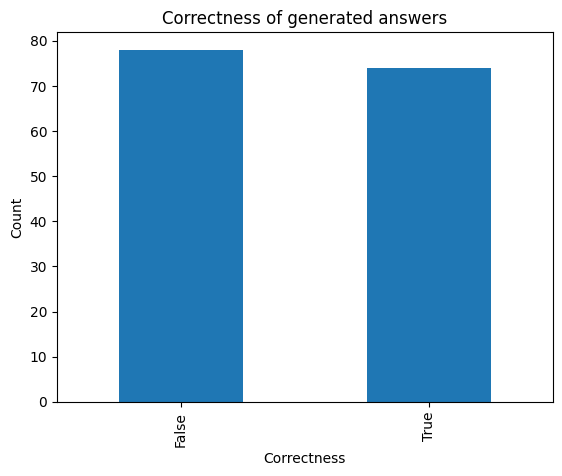

In [14]:
# How to process the log events generated by oaieval
#events = "/tmp/evallogs/{log_name}"

with open(events, "r") as f:
    events_df = pd.read_json(f, lines=True)

matches_df = events_df[events_df.type == "match"].reset_index(drop=True)
matches_df = matches_df.join(pd.json_normalize(matches_df.data))
matches_df.correct.value_counts().plot.bar(title="Correctness of generated answers", xlabel="Correctness", ylabel="Count")

In [15]:
# Inspect samples
for i, r in pd.json_normalize(events_df[events_df.type == "sampling"].data).iterrows():
    print(f"Prompt: {r.prompt}")
    print(f"Sampled: {r.sampled}")
    print("-" * 25)

Prompt: [{'role': 'system', 'content': 'Examine the provided text and classify weather it is generated by GPT model text-davinci-001 or not. Provide your reasoning step by step, and at the end, write your final answer, yes or no, enclosed in square brackets like [Yes] or [No].'}, {'role': 'user', 'content': "Diary of a Wimpy Kid is a novel series by Jeff Kinney that chronicles the humorous journey of Greg Heffley, an adolescent middle-schooler who struggles to survive the awkwardness and embarrassment of passing through adolescence. Through Greg's relatable experiences and first-person narration, readers follow him as he navigates his everyday life and embarks on an epic family road trip. With his best friend, Rowley, by his side, Greg faces the struggles of trying to fit in, dealing with backstabbing bullies, and engaging in family dynamics. Along the way, Greg discovers what matters most in life and the courage to stand up for what he believes in."}]
Sampled: ['[No]']
---------------

In [16]:
%cd /content/
!git clone https://github.com/xinzhel/llm_eval.git

/content
Cloning into 'llm_eval'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 42 (delta 4), reused 37 (delta 1), pack-reused 0
Receiving objects: 100% (42/42), 573.10 KiB | 2.37 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [17]:
!pip install openai -q

In [18]:
from openai import OpenAI

client = OpenAI()

stream = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": "Say this is a test"}],
    stream=True,
)
for chunk in stream:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

This is a test.

In [25]:
!pip install openai==0.28 -q

In [6]:
import argparse
import openai
import os
import numpy as np
import pandas as pd
import time

%cd /content/llm_eval/
from utils.crop import crop
%cd /content/


#openai.api_key = "openai_api_key"
choices = ["A", "B", "C", "D"]


def softmax(x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator
    return softmax

def format_subject(subject):
    l = subject.split("_")
    s = ""
    for entry in l:
        s += " " + entry
    return s

def format_example(df, idx, include_answer=True):
    prompt = df.iloc[idx, 0]
    k = df.shape[1] - 2
    for j in range(k):
        prompt += "\n{}. {}".format(choices[j], df.iloc[idx, j+1])
    prompt += "\nAnswer:"
    if include_answer:
        prompt += " {}\n\n".format(df.iloc[idx, k + 1])
    return prompt

def gen_prompt(train_df, subject, k=-1):
    prompt = "The following are multiple choice questions (with answers) about {}.\n\n".format(format_subject(subject))
    if k == -1:
        k = train_df.shape[0]
    for i in range(k):
        prompt += format_example(train_df, i)
    return prompt

def eval(args, subject, engine, dev_df, test_df):

    cors = []
    all_probs = []
    answers = choices[:test_df.shape[1]-2]

    for i in range(test_df.shape[0]):
        # get prompt and make sure it fits
        k = args.ntrain
        prompt_end = format_example(test_df, i, include_answer=False)
        train_prompt = gen_prompt(dev_df, subject, k)
        prompt = train_prompt + prompt_end

        while crop(prompt) != prompt:
            k -= 1
            train_prompt = gen_prompt(dev_df, subject, k)
            prompt = train_prompt + prompt_end

        label = test_df.iloc[i, test_df.shape[1]-1]

        c = openai.Completion.create(
            engine=engine,
            prompt=prompt,
            max_tokens=1,
            logprobs=100,
            temperature=0,
            echo=True
        )

        lprobs = []
        for ans in answers:
            try:
                lprobs.append(c["choices"][0]["logprobs"]["top_logprobs"][-1][" {}".format(ans)])
            except:
                print("Warning: {} not found. Artificially adding log prob of -100.".format(ans))
                lprobs.append(-100)
        pred = {0: "A", 1: "B", 2: "C", 3: "D"}[np.argmax(lprobs)]
        probs = softmax(np.array(lprobs))

        cor = pred == label
        cors.append(cor)
        all_probs.append(probs)

    acc = np.mean(cors)
    cors = np.array(cors)

    all_probs = np.array(all_probs)
    print("Average accuracy {:.3f} - {}".format(acc, subject))

    return cors, acc, all_probs


    #parser.add_argument("--ntrain", "-k", type=int, default=5)
    #parser.add_argument("--data_dir", "-d", type=str, default="data")
    #parser.add_argument("--save_dir", "-s", type=str, default="results")

    data_args = parser.parse_args()
    engine = "davinci"
    # file_names = sorted([f.split("_test.csv")[0] for f in os.listdir(os.path.join(args.data_dir, "test")) if "_test.csv" in f])
    subject = "machine_learning"

    data_dir='/content/data'
    save_dir='/content/results'
    ntrain='5'

    # read in data
    dev_df = pd.read_csv(os.path.join(data_dir, "dev", subject + "_dev.csv"), header=None)[:ntrain]
    test_df = pd.read_csv(os.path.join(data_dir, "test", subject + "_test.csv"), header=None)[:10]

    # get prompt and make sure it fits
    k = data_args.ntrain
    prompt_end = format_example(test_df, 0, include_answer=False)
    train_prompt = gen_prompt(dev_df, subject, k)
    prompt = train_prompt + prompt_end

    while crop(prompt) != prompt:
        k -= 1
        train_prompt = gen_prompt(dev_df, subject, k)
        prompt = train_prompt + prompt_end

    label = test_df.iloc[0, test_df.shape[1]-1]

    c = openai.Completion.create(
        engine=engine,
        prompt=prompt,
        max_tokens=1,
        logprobs=100,
        temperature=0,
        echo=True
    )

    lprobs = []

    answers = choices[:test_df.shape[1]-2]
    for ans in answers:
        try:
            lprobs.append(c["choices"][0]["logprobs"]["top_logprobs"][-1][" {}".format(ans)])
        except:
            print("Warning: {} not found. Artificially adding log prob of -100.".format(ans))
            lprobs.append(-100)
    pred = {0: "A", 1: "B", 2: "C", 3: "D"}[np.argmax(lprobs)]
    probs = softmax(np.array(lprobs))

    cor = pred == label

/content/llm_eval
/content


In [21]:
def chat_gpt_textgen(prompt):
    response = client.chat.completions.create(
      model="gpt-3.5-turbo",
      #model="gpt-4",
      #model="gpt-4-turbo-preview",
      #model=modelid,
      messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
      ]
    )
    #return response.choices[0].message.content
    return response
    #print(response.choices[0].message.content)

In [22]:
!pip install openai==0.28 -q

In [4]:
import colab_env
import os
import openai

openai.api_key = os.environ["OPENAI_API_KEY"]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
if __name__ == "__main__":
    #parser = argparse.ArgumentParser()
    #parser.add_argument("--ntrain", "-k", type=int, default=5)
    #parser.add_argument("--data_dir", "-d", type=str, default="data")
    #parser.add_argument("--save_dir", "-s", type=str, default="results")

    #data_args = parser.parse_args()
    #engine = "davinci"
    # file_names = sorted([f.split("_test.csv")[0] for f in os.listdir(os.path.join(args.data_dir, "test")) if "_test.csv" in f])
    subject = "machine_learning"

    data_dir='/content/data'
    save_dir='/content/results'
    ntrain=5

    # read in data
    dev_df = pd.read_csv(os.path.join(data_dir, "dev", subject + "_dev.csv"), header=None)[:ntrain]
    test_df = pd.read_csv(os.path.join(data_dir, "test", subject + "_test.csv"), header=None)[:1]

    #del choices
    # get prompt and make sure it fits
    k = ntrain
    prompt_end = format_example(test_df, 0, include_answer=False)
    train_prompt = gen_prompt(dev_df, subject, k)
    prompt = train_prompt + prompt_end

    while crop(prompt) != prompt:
        k -= 1
        train_prompt = gen_prompt(dev_df, subject, k)
        prompt = train_prompt + prompt_end

    label = test_df.iloc[0, test_df.shape[1]-1]

    #print(prompt)

    #print('label: %s'%label)
    #c=chat_gpt_textgen(prompt)
    #print(prompt_end[:])
    #print(c)

    engine="davinci-002"
    #c = client.chat.completions.create(

    c = openai.Completion.create(
        model=engine,
        prompt=prompt,
        max_tokens=1,
        logprobs=100,
        temperature=0.9,
        echo=True
    )

    lprobs = []
    #print(c)

    answers = choices[:test_df.shape[1]-2]
    #print(answers)
    n=0
    for ans in answers:
        #print(ans)
        n+=1
        print('id: %s'%n)
        try:
            #print(c["choices"][0]["logprobs"]["top_logprobs"][-1][" {}".format(ans)])
            print(ans,label)
            print()
            lprobs.append(c["choices"][0]["logprobs"]["top_logprobs"][-1][" {}".format(ans)])
        except:
            print("Warning: {} not found. Artificially adding log prob of -100.".format(ans))
            lprobs.append(-100)
    pred = {0: "A", 1: "B", 2: "C", 3: "D"}[np.argmax(lprobs)]
    probs = softmax(np.array(lprobs))
    #pred='D'
    print()
    print(pred)
    print(probs)
    cor = pred == label
    print(cor)

id: 1
A D

id: 2
B D

id: 3
C D

id: 4
D D


C
[0.28250601 0.178679   0.37855434 0.16026065]
False
